<h1>CSE483 Computer Vision Major Task - Phase 2</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import Libraries
- Use "pip install libName" in terminal if any of them is not installed on your machine.

In [1]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import scipy
import glob
import random
from skimage.feature import hog
from collections import Counter
from operator import itemgetter
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Custom Fns

In [2]:
# Define the HOG parameters
cell_size = (8, 8)
block_size = (16, 16)
orientations = 9

In [42]:
# Fn import pics, labels, true boxes
def getPics(chosen_set):
    images = []
    labels = []
    selected_boxes = []
    true_boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)
    with open('phase1OutputTrain.json') as f:
        boxes = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            if (data[i]['boxes'][j]['label']==10):
                temp.append(0)
            else:
                temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        selected_boxes.append(boxes[i]['selected_boxes'+str(i)])
        true_boxes.append(data[i]['boxes'])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    return images, labels, selected_boxes, true_boxes

In [43]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15), cmap = "RGB",title=" "):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize, constrained_layout=True)
    n = 0
    if (nb_rows == 1 and nb_cols ==1):
        plt.imshow(images[0],cmap=cmap)
    elif(nb_rows == 1 or nb_cols ==1):
            for i in range(0, nb_cols+nb_rows-1):
                axs[i].axis('off')
                if(cmap=="gray"):
                    axs[i].imshow(images[n],cmap="gray")
                else:
                    axs[i].imshow(images[n])
                n += 1
    else:
        for i in range(0, nb_rows):
            for j in range(0, nb_cols):
                axs[i, j].axis('off')
                if(cmap=="gray"):
                    axs[i][j].imshow(images[n],cmap="gray")
                else:
                    axs[i][j].imshow(images[n])
                n += 1
    plt.suptitle(title)
    plt.show()


In [45]:
train_images_all, train_labels_all, train_selected_boxes_all, train_true_boxes_all = getPics("train")

There are  33402  images in train set.


In [46]:
def split_dataset(indices, images=train_images_all, labels=train_labels_all, true_boxes=train_true_boxes_all, selected_boxes=train_selected_boxes_all):
    images_splitted = []
    labels_splitted = []
    true_boxes_splitted = []
    selected_boxes_splitted = []

    for i in range(len(indices)):
        true_boxes_splitted.append(np.array(train_true_boxes_all)[indices[i]].tolist())
        selected_boxes_splitted.append(np.array(train_selected_boxes_all)[indices[i]].tolist())
        images_splitted.append(np.array(train_images_all)[indices[i]].tolist())
        labels_splitted.append(np.array(train_labels_all)[indices[i]].tolist())
    
    return images_splitted, labels_splitted, true_boxes_splitted, selected_boxes_splitted

In [74]:
def split_boxes_area(images, boxes, n_groups):
    boxes_ratio = []
    i = 0
    for box, img in zip(boxes, images):
        sum = 0
        for b in box:
            sum += (abs(box[1] - box[3]) * abs(box[0] - box[2]))
        boxes_ratio.append([sum / (img.shape[0]*img.shape[1]), i])
        i += 1
        
    boxes_ratio = sorted(boxes_ratio, key=itemgetter(0))
    # print("Max label area percentage of the image size is:", boxes_ratio[-1][0], "with index", boxes_ratio[-1][1] + 1)
    # print("Min label area percentage of the image size is:", boxes_ratio[0][0], "with index", boxes_ratio[0][1] + 1)

    boxes_ratio = np.array(boxes_ratio)

    # imgs_median_size = statistics.median(boxes_ratio[:,0])
    # imgs_mean_size = statistics.mean(boxes_ratio[:, 0])
    # print("Average image size is:", imgs_mean_size)
    # print("Median image size is:", imgs_median_size)

    boxes_ratio_splitted = np.array_split(boxes_ratio, n_groups)
    boxes_ratio_splitted = np.array(boxes_ratio_splitted)
    indices = []

    for i in range(n_groups):
        indices.append(list(boxes_ratio_splitted[i][:, 1].astype(int)))
        print(len(indices[i]))
        
    return indices

In [48]:
def split_resolution(images, n_groups):
    image_sizes = []
    i = 0
    for img in images:
        image_sizes.append([img.shape[0]*img.shape[1], i])
        i += 1
        
    image_sizes = sorted(image_sizes, key=itemgetter(0))
    image_sizes = np.array(image_sizes)
    image_sizes_splitted = np.array_split(image_sizes, n_groups)
    image_sizes_splitted = np.array(image_sizes_splitted)
    indices = []

    for i in range(n_groups):
        indices.append(list(image_sizes_splitted[i][:, 1].astype(int)))
        print(len(indices[i]))
    return indices

In [49]:
def split_histogram(images, n_groups):
    image_hists = []

    i = 0
    for img in images:
        hist = cv2.calcHist(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY), [0], None, [256], [0, 256]).flatten()
        weighted_avg = 0
        for j in range(len(hist)):
            weighted_avg += (j + 1) * hist[j] / 256
        weighted_avg /= img.shape[0] * img.shape[1]
        image_hists.append([weighted_avg, i])
        i+=1

    image_hists = sorted(image_hists, key=itemgetter(0))
    image_hists = np.array(image_hists)
    image_hists_splitted = np.array_split(image_hists, n_groups)
    image_hists_splitted = np.array(image_hists_splitted)
    indices = []
    
    for i in range(n_groups):
        indices.append(list(image_hists_splitted[i][:, 1].astype(int)))
        print(len(indices[i]))
    return indices

In [50]:
def cropImages(image, boxes):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    cropped = []
    for box in boxes:
        cropped.append(img[box[1]:box[3], box[0]:box[2]])
    return cropped

In [51]:
def getTemplatesPics():
    templates = []
    labels = []
    picsFolder_path = "Matching2/"

    srtd_dir = sorted(glob.glob(picsFolder_path + "/*.jpg"))
    # import colored pictures
    for image_path in srtd_dir:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        template = {'label':int(image_path[10]), 'image':image}
        templates.append(template)
    return templates

In [52]:
def extract_hog_features(image):
    resized_image = cv2.resize(image, (64, 128))
    hog = cv2.HOGDescriptor()
    hog_features = hog.compute(resized_image)
    hog_features = np.array(hog_features).flatten()
    return hog_features

In [53]:
def getTemplatesHOGs():
    templates = getTemplatesPics()
    full_templates = []
    for template in templates:
        template['descriptor'] = extract_hog_features(template['image'])
        full_templates.append(template)
    return full_templates

In [54]:
def calcPicTrue(trueLabels, predictedLabels):
    truePredictions = list((Counter(trueLabels) & Counter(predictedLabels)).elements())
    return len(truePredictions)

In [55]:
def min_squared_difference(img_hog, tmps_hogs):
    img_hog = np.array(img_hog)
    tmps_hogs = np.array(tmps_hogs)
    return np.argmin(np.sum((tmps_hogs - img_hog) ** 2, axis=1))

In [56]:
def predictImage(image, boxes, tmps_data, tmps_labels):
    croppedImages = cropImages(image,boxes)
    predictions = []
    for img in croppedImages:
        img_hog = extract_hog_features(img)
        idx = min_squared_difference(img_hog, tmps_data)
        predictions.append(tmps_labels[idx])
    return predictions

# Algorithm steps on sample random image

#### Prepare Templates for feature matching:

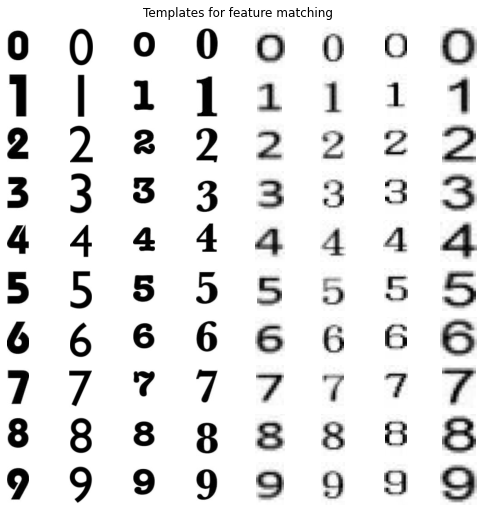

In [57]:
templates = getTemplatesPics()
plot_image_grid([tmp['image'] for tmp in templates],10,int(len(templates)/10),figsize=(7,7),cmap='gray',title="Templates for feature matching")

- Extract templates features using HOG

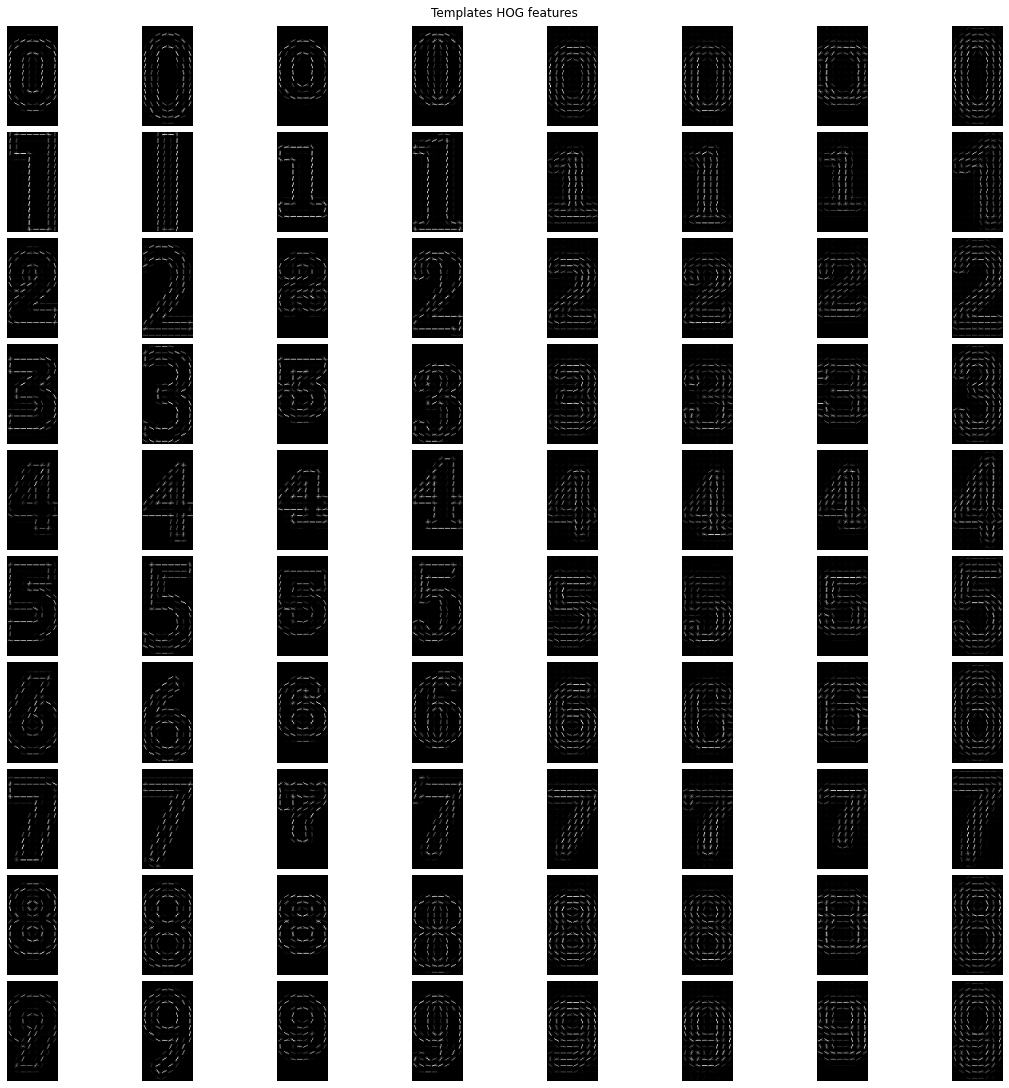

In [58]:
templates_hogs_imgs = []
templates = getTemplatesHOGs()

for tmp in templates:
    hog_features, hog_image = hog(cv2.resize(tmp['image'], (64, 128)), visualize=True)
    templates_hogs_imgs.append(hog_image)

plot_image_grid(templates_hogs_imgs,10,int(len(templates)/10),cmap='gray',title="Templates HOG features")

Picture number:  11623
True Labels: [3. 5.]


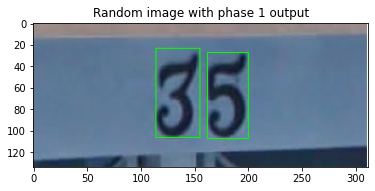

In [59]:
idx = random.randint(0, len(train_images_all)-1)
trialImage = train_images_all[idx].copy()
trialImage = cv2.cvtColor(trialImage,cv2.COLOR_BGR2RGB)
print("Picture number: ", idx+1)
plt.title("Random image with phase 1 output")
print("True Labels:", train_labels_all[idx])
imgBoxes = trialImage.copy()
for i in train_selected_boxes_all[idx]:
    cv2.rectangle(imgBoxes,
                  (i[0],i[1]),
                  (i[2],i[3]),
                  (0,255,0), 1)
plt.imshow(imgBoxes)
plt.show()


- Convert to grayscale & Crop out boxes from phase 1

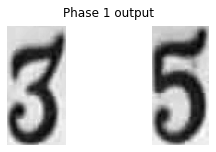

In [60]:
if(len(train_selected_boxes_all[idx])!=0):
    croppedTrial = cropImages(trialImage,train_selected_boxes_all[idx])
    plot_image_grid(croppedTrial,1,len(croppedTrial),figsize=(2*len(croppedTrial),2),cmap='gray',title="Phase 1 output")
else:
    print("No digits localized in phase 1")

- Extract HOG features for the cropped images

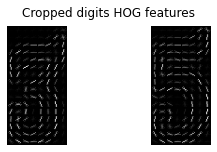

In [61]:
if(len(train_selected_boxes_all[idx])!=0):
    cropped_hogs_imgs = []

    for img in croppedTrial:
        hog_features, hog_image = hog(cv2.resize(img, (64, 128)), visualize=True)
        cropped_hogs_imgs.append(hog_image)
    plot_image_grid(cropped_hogs_imgs,1,len(cropped_hogs_imgs),figsize=(2*len(cropped_hogs_imgs),2),cmap='gray',title="Cropped digits HOG features")
else:
    print("No digits localized in phase 1")

- Match each cropped digit HOG to the closest template HOG using minimum squared distance

Prediction using feature matching: [3, 5]
True Labels are:  [3. 5.]
Recognition Accuracy for Localized digits: 100.0%
Localization + Recognition Accuracy for all image digits 100.0%


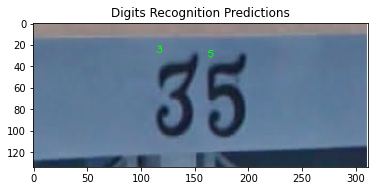

In [62]:
if(len(train_selected_boxes_all[idx])!=0):

        predictions = []
        trialImage2 = trialImage.copy()
        for img, pos in zip(croppedTrial, train_selected_boxes_all[idx]):
                img_hog = extract_hog_features(img)
                tmp_idx = min_squared_difference(img_hog, [temp['descriptor'] for temp in templates])
                prediction = templates[tmp_idx]['label']
                predictions.append(prediction)
                cv2.putText(trialImage2, str(prediction), (pos[0],pos[1]+4), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.3, (0, 255, 0), 1)

        print("Prediction using feature matching:",predictions)
        print("True Labels are: ",train_labels_all[idx])
        print("Recognition Accuracy for Localized digits:",str(calcPicTrue(train_labels_all[idx],predictions)*100/len(predictions))+"%")
        print("Localization + Recognition Accuracy for all image digits",str(calcPicTrue(train_labels_all[idx],predictions)*100 / len(train_labels_all[idx]))+"%")
        plt.imshow(trialImage2)
        plt.title("Digits Recognition Predictions")
        plt.show()
else:
        print("No digits localized in phase 1")
        print("Recognition Accuracy for Localized digits: 0%")
        print("Localization + Recognition Accuracy for all image digits 0%")
        

In [64]:
templates = getTemplatesHOGs()
tmps_data = [temp['descriptor'] for temp in templates]
tmps_labels = [temp['label'] for temp in templates]

predicted_labels_sum = 0
true_prediction_sum = 0
true_labels_len = 0

for image, boxes, label in zip(train_images_all, train_selected_boxes_all, train_labels_all):
    true_labels_len+= len(label)
    if(len(boxes)==0):
        continue
    predicted_labels = predictImage(image, boxes, tmps_data, tmps_labels)
    predicted_labels_sum += len(predicted_labels)
    true_prediction_len = calcPicTrue(list(label), predicted_labels)
    true_prediction_sum += true_prediction_len
print("Total Recognition Accuracy for phase 1 output boxes",true_prediction_sum*100 / predicted_labels_sum, "%")
print("Total Recognition Accuracy for all train data boxes",true_prediction_sum*100 / true_labels_len, "%")

Total Recognition Accuracy for phase 1 output boxes 72.46940805119557
Total Recognition Accuracy for all train data boxes 45.75671949438279


------------------------------

### 3- Testing on data groups split according to image size

- Split according to image size

In [65]:
n_groups = 3
res_indices = split_resolution(train_images_all, n_groups)
images_res_splitted, labels_res_splitted, true_boxes_res_splitted, selected_boxes_res_splitted = split_dataset(res_indices)

11134
11134
11134


- Run localization algorithm, testing to find results.

In [66]:
templates = getTemplatesHOGs()
tmps_data = [temp['descriptor'] for temp in templates]
tmps_labels = [temp['label'] for temp in templates]

group_names =[]
phase1 = []
train_data_boxes = []

for i in range(n_groups):
    print("Resolution group",i+1)
    group_names.append("Group "+str(i+1))
    
    predicted_labels_sum = 0
    true_prediction_sum = 0
    true_labels_len = 0

    for image, boxes, label in zip(images_res_splitted[i], selected_boxes_res_splitted[i], labels_res_splitted[i]):
        true_labels_len+= len(label)
        if(len(boxes)==0):
            continue
        predicted_labels = predictImage(image, boxes, tmps_data, tmps_labels)
        predicted_labels_sum += len(predicted_labels)
        true_prediction_len = calcPicTrue(list(label), predicted_labels)
        true_prediction_sum += true_prediction_len

    phase1.append(true_prediction_sum*100 / predicted_labels_sum)
    train_data_boxes.append(true_prediction_sum*100 / true_labels_len)
    print("Total Recognition Accuracy for phase 1 output boxes",true_prediction_sum*100 / predicted_labels_sum)
    print("Total Recognition Accuracy for train data boxes",true_prediction_sum*100 / true_labels_len)


Resolution group 1
Total Recognition Accuracy for phase 1 output boxes 63.94541910331384
Total Recognition Accuracy for train data boxes 34.95290457315774
Resolution group 2
Total Recognition Accuracy for phase 1 output boxes 76.8492726709997
Total Recognition Accuracy for train data boxes 52.216520861372814
Resolution group 3
Total Recognition Accuracy for phase 1 output boxes 74.70186407317355
Total Recognition Accuracy for train data boxes 49.596433238527176


- Visualize results:

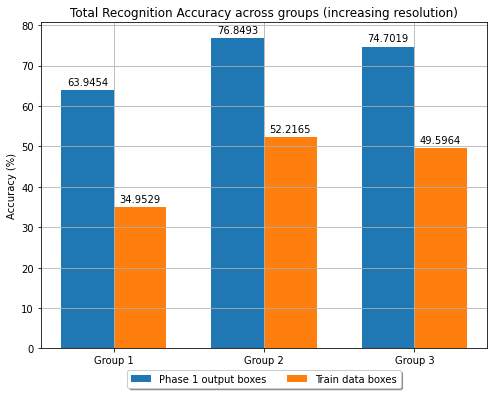

In [67]:
x = np.arange(len(group_names))
width = 0.35 
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, phase1, width, label='Phase 1 output boxes')
rects2 = ax.bar(x + width/2, train_data_boxes, width, label='Train data boxes')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Group')
ax.set_xticks(x, group_names)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Total Recognition Accuracy across groups (increasing resolution)")
plt.grid()
plt.show()

### 4- Testing on data groups split according to numbers area to image size ratio

- Split according to numbers size in images

In [68]:
n_groups = 3
area_indices = split_boxes_area(train_images_all, train_selected_boxes_all, n_groups)
images_area_splitted, labels_area_splitted, true_boxes_area_splitted, selected_boxes_area_splitted = split_dataset(area_indices)

11134
11134
11134


- Run localization algorithm, testing to find results.

In [69]:
templates = getTemplatesHOGs()
tmps_data = [temp['descriptor'] for temp in templates]
tmps_labels = [temp['label'] for temp in templates]

group_names =[]
phase1 = []
train_data_boxes = []

for i in range(n_groups):
    print("Area group",i+1)
    group_names.append("Group "+str(i+1))
    
    predicted_labels_sum = 0
    true_prediction_sum = 0
    true_labels_len = 0

    for image, boxes, label in zip(images_area_splitted[i], selected_boxes_area_splitted[i], labels_area_splitted[i]):
        true_labels_len+= len(label)
        if(len(boxes)==0):
            continue
        predicted_labels = predictImage(image, boxes, tmps_data, tmps_labels)
        predicted_labels_sum += len(predicted_labels)
        true_prediction_len = calcPicTrue(list(label), predicted_labels)
        true_prediction_sum += true_prediction_len

    phase1.append(true_prediction_sum*100 / predicted_labels_sum)
    train_data_boxes.append(true_prediction_sum*100 / true_labels_len)
    print("Total Recognition Accuracy for phase 1 output boxes",true_prediction_sum*100 / predicted_labels_sum)
    print("Total Recognition Accuracy for train data boxes",true_prediction_sum*100 / true_labels_len)

Area group 1
Total Recognition Accuracy for phase 1 output boxes 69.09186667669852
Total Recognition Accuracy for train data boxes 40.69937508310065
Area group 2
Total Recognition Accuracy for phase 1 output boxes 72.01817001946787
Total Recognition Accuracy for train data boxes 46.77174645987863
Area group 3
Total Recognition Accuracy for phase 1 output boxes 75.4230046145958
Total Recognition Accuracy for train data boxes 49.09515686419936


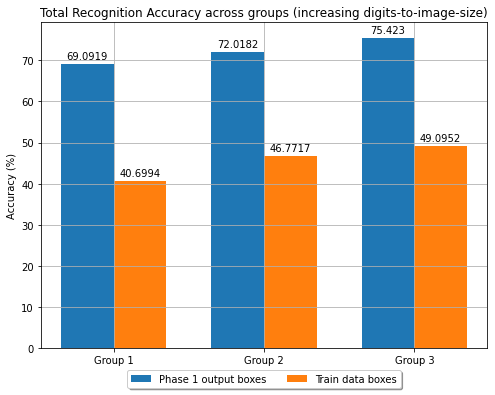

In [70]:
x = np.arange(len(group_names))
width = 0.35 
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, phase1, width, label='Phase 1 output boxes')
rects2 = ax.bar(x + width/2, train_data_boxes, width, label='Train data boxes')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Group')
ax.set_xticks(x, group_names)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Total Recognition Accuracy across groups (increasing digits-to-image-size)")
plt.grid()
plt.show()

### 5- Testing on data groups split according to grayscale histogram weighted average (brightness).

- Split according to grayscale histogram weighted average (brightness)

In [71]:
n_groups = 3
hist_indices = split_histogram(train_images_all, n_groups)
images_hist_splitted, labels_hist_splitted, true_boxes_hist_splitted, selected_boxes_hist_splitted = split_dataset(hist_indices)

11134
11134
11134


- Run localization algorithm, testing to find results.

In [72]:
templates = getTemplatesHOGs()
tmps_data = [temp['descriptor'] for temp in templates]
tmps_labels = [temp['label'] for temp in templates]

group_names =[]
phase1 = []
train_data_boxes = []

for i in range(n_groups):
    print("Histogram group",i+1)
    group_names.append("Group "+str(i+1))
    
    predicted_labels_sum = 0
    true_prediction_sum = 0
    true_labels_len = 0

    for image, boxes, label in zip(images_hist_splitted[i], selected_boxes_hist_splitted[i], labels_hist_splitted[i]):
        true_labels_len+= len(label)
        if(len(boxes)==0):
            continue
        predicted_labels = predictImage(image, boxes, tmps_data, tmps_labels)
        predicted_labels_sum += len(predicted_labels)
        true_prediction_len = calcPicTrue(list(label), predicted_labels)
        true_prediction_sum += true_prediction_len

    phase1.append(true_prediction_sum*100 / predicted_labels_sum)
    train_data_boxes.append(true_prediction_sum*100 / true_labels_len)
    print("Total Recognition Accuracy for phase 1 output boxes",true_prediction_sum*100 / predicted_labels_sum)
    print("Total Recognition Accuracy for train data boxes",true_prediction_sum*100 / true_labels_len)

Histogram group 1
Total Recognition Accuracy for phase 1 output boxes 74.9908614597295
Total Recognition Accuracy for train data boxes 48.93845419847328
Histogram group 2
Total Recognition Accuracy for phase 1 output boxes 73.41209349593495
Total Recognition Accuracy for train data boxes 48.776164753544904
Histogram group 3
Total Recognition Accuracy for phase 1 output boxes 68.48041997729852
Total Recognition Accuracy for train data boxes 39.5468884427875


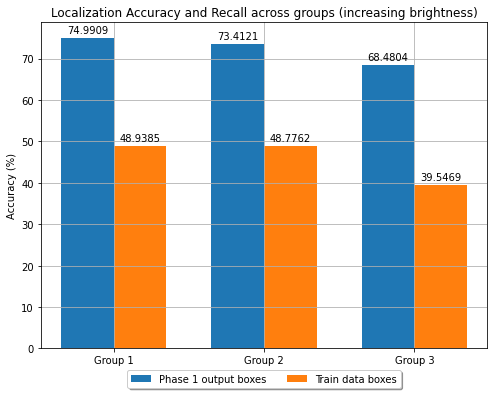

In [73]:
x = np.arange(len(group_names))
width = 0.35 
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, phase1, width, label='Phase 1 output boxes')
rects2 = ax.bar(x + width/2, train_data_boxes, width, label='Train data boxes')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Group')
ax.set_xticks(x, group_names)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Localization Accuracy and Recall across groups (increasing brightness)")
plt.grid()
plt.show()